In [1]:
from functools import partial

import matplotlib.pyplot as plt
import numpy as np

from superfv import EulerSolver, plot_2d_slice, turbulent_power_specta
from superfv.initial_conditions import decaying_isotropic_turbulence

In [2]:
seed = 1
N = 64
T = [0.05, 0.1, 0.15]

configs = {
    "p0": dict(riemann_solver="hllc", p=0),
    "MUSCL-Hancock": dict(
        riemann_solver="hllc",
        p=1,
        MUSCL=True,
        MUSCL_limiter="PP2D",
        flux_recipe=2,
    ),
    "ZS3": dict(
        riemann_solver="hllc",
        p=3,
        flux_recipe=2,
        lazy_primitives=True,
        ZS=True,
        GL=True,
        include_corners=True,
        PAD={"rho": (0, None)},
    ),
    "MM3": dict(
        riemann_solver="hllc",
        p=3,
        flux_recipe=2,
        lazy_primitives=True,
        MOOD=True,
        limiting_vars=("rho", "vx"),
        cascade="muscl",
        MUSCL_limiter="moncen",
        max_MOOD_iters=1,
        NAD=True,
        NAD_rtol=1e-1,
        NAD_atol=1e-8,
        include_corners=True,
        PAD={"rho": (0, None)},
    ),
}

In [3]:
sims = {}
for name, config in configs.items():
    print(f"Running simulation: {name}")
    sim = EulerSolver(
        ic=partial(decaying_isotropic_turbulence, seed=seed, M=10, slope=-5 / 3),
        isothermal=True,
        nx=N,
        ny=N,
        **config,
    )

    try:
        sim.run(
            T,
            q_max=2,
            allow_overshoot=True,
            muscl_hancock=config.get("MUSCL", False),
            log_freq=20,
        )
        sims[name] = sim
    except RuntimeError as e:
        print(f"Simulation '{name}' failed: {e}")

Running simulation: p0
Step #208 @ t=1.50e-01 | dt=1.09e-03 | min(rho)=1.79e-02, min(P)=1.79e-02 | (done)                  
Running simulation: MUSCL-Hancock
Step #228 @ t=1.50e-01 | dt=9.95e-04 | min(rho)=3.26e-02, min(P)=3.26e-02 | (done)                  
Running simulation: ZS3
Step #228 @ t=1.50e-01 | dt=1.00e-03 | min(rho)=1.85e-02, min(P)=1.85e-02 | (done)                  
Running simulation: MM3
Step #229 @ t=1.50e-01 | dt=1.00e-03 | min(rho)=1.28e-02, min(P)=1.28e-02 | (done)                  


In [4]:
sim = sims["p0"]
idx = sim.variable_index_map

vx = sim.snapshots[0]["w"][idx("vx")]
vy = sim.snapshots[0]["w"][idx("vy")]

print(np.std(vx), np.std(vy))

5.474417501368068 8.368437908039647


/Users/jonathan/Desktop/superfv/superfv/visualization.py:38: UserWarning: Cell-centered coordinate 0.05 not exactly matched in mesh; using nearest: 0.0503322
  warnings.warn(
/Users/jonathan/Desktop/superfv/superfv/visualization.py:38: UserWarning: Cell-centered coordinate 0.05 not exactly matched in mesh; using nearest: 0.0503322
  warnings.warn(
/Users/jonathan/Desktop/superfv/superfv/visualization.py:38: UserWarning: Cell-centered coordinate 0.1 not exactly matched in mesh; using nearest: 0.100414
  warnings.warn(
/Users/jonathan/Desktop/superfv/superfv/visualization.py:38: UserWarning: Cell-centered coordinate 0.1 not exactly matched in mesh; using nearest: 0.100414
  warnings.warn(
/Users/jonathan/Desktop/superfv/superfv/visualization.py:38: UserWarning: Cell-centered coordinate 0.15 not exactly matched in mesh; using nearest: 0.150474
  warnings.warn(
/Users/jonathan/Desktop/superfv/superfv/visualization.py:38: UserWarning: Cell-centered coordinate 0.15 not exactly matched in mes

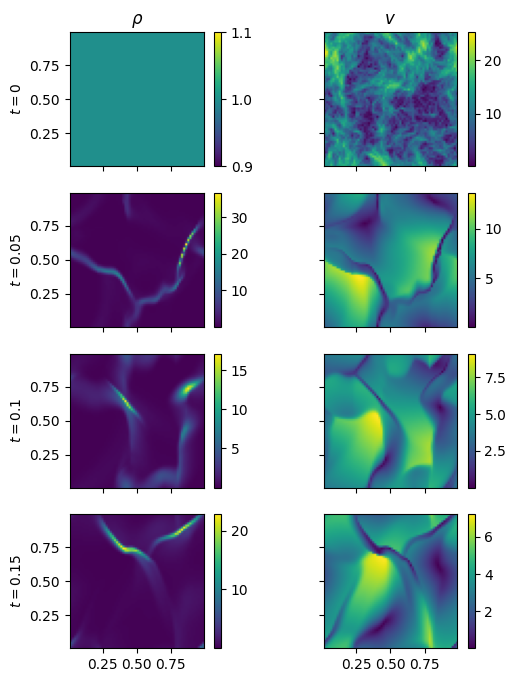

In [5]:
sim = sims["p0"]

fig, axs = plt.subplots(
    len(T) + 1, 2, sharex=True, sharey=True, figsize=(6, (len(T) + 1) * 2)
)

axs[0, 0].set_title(r"$\rho$")
axs[0, 1].set_title(r"$v$")

for i, t in enumerate([0] + T):
    axs[i, 0].set_ylabel(f"$t={t}$")
    plot_2d_slice(sim, axs[i, 0], "rho", cell_averaged=True, colorbar=True, t=t)
    plot_2d_slice(sim, axs[i, 1], "v", cell_averaged=True, colorbar=True, t=t)

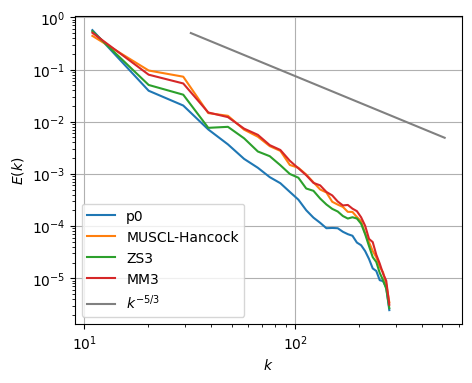

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(5, 4))
ax.set_xlabel(r"$k$")
ax.set_ylabel(r"$E(k)$")
ax.set_xscale("log")
ax.set_yscale("log")

for name, sim in sims.items():
    w = sim.snapshots[-1]["w"]
    k_centers, E_k = turbulent_power_specta(
        sim.xp, sim.variable_index_map, w, sim.mesh, nbins=30, binmode="linear"
    )

    ax.plot(k_centers, E_k, marker="none", mfc="none", linestyle="-", label=name)

ax.plot(
    [32, 512], [5e-1, 5e-1 * (512 / 32) ** (-5 / 3)], label=r"$k^{-5/3}$", color="gray"
)

ax.legend()
ax.grid()